In [3]:
import tensorflow as tf
import keras
import cv2
import numpy as np
import itertools
import os
# import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,Activation,BatchNormalization

import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax


In [4]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
    plt.figure(figsize=(10, 10))  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()        
        plt.axis('off')
        plt.imshow(img, cmap='gray') 

In [5]:
train_dir = "data/train" #passing the path with training images
test_dir = "data/test"  #passing the path with testing images

## ANGRY

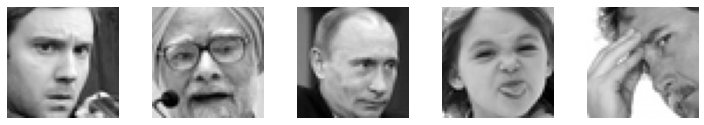

In [6]:
plot_images(train_dir+'/angry')

## DISGUST

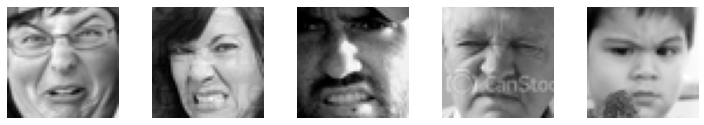

In [7]:
plot_images(train_dir+'/disgust')

## FEAR

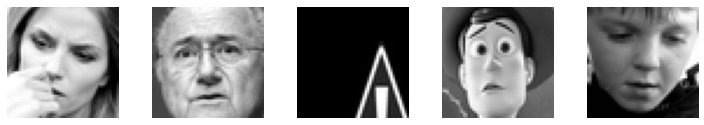

In [8]:
plot_images(train_dir+'/fear')

## HAPPY

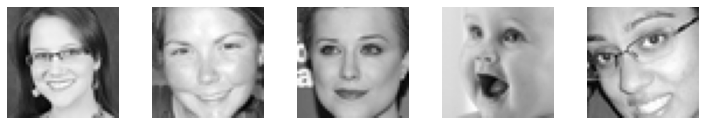

In [9]:
plot_images(train_dir+'/happy')

## NEUTRAL

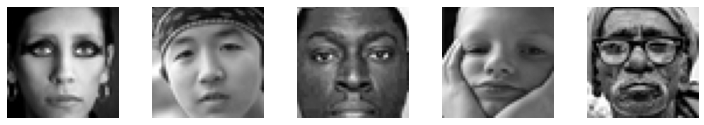

In [10]:
plot_images(train_dir+'/neutral')

## SAD

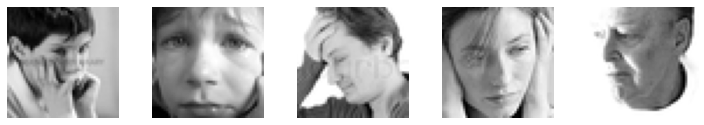

In [11]:
plot_images(train_dir+'/sad')

## SURPRISE

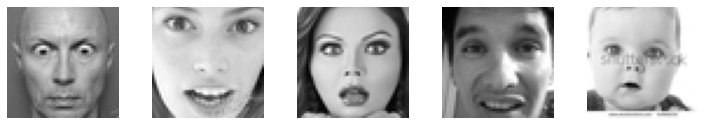

In [12]:
plot_images(train_dir+'/surprise')

 ### Plotting the number of images in each emotion folders

In [13]:
def plot_bar_chart_diagram(path_data):
  dic={}
  for emotion in  os.listdir(path_data):
    dem=0
    for x in os.listdir(path_data+"/"+emotion):
      dem+=1
    dic[emotion]=dem
  print(dic)
  barlist=plt.bar(range(len(dic)), list(dic.values()),tick_label=list(dic.keys()))
#set color
  plt.show()

{'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}


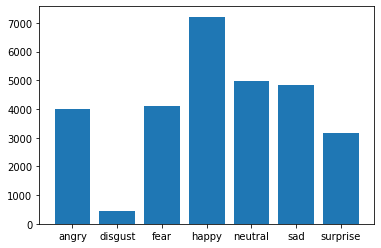

In [14]:
plot_bar_chart_diagram(train_dir)

{'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


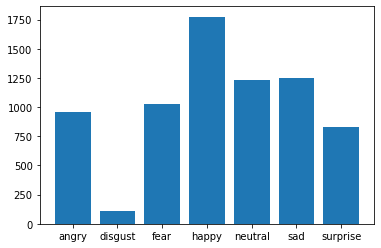

In [15]:
plot_bar_chart_diagram(test_dir)

In [16]:
img_size = 48

## Data Augmentation

In [17]:
train_data_gen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255
                                         )
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        'data/train',
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical')

validation_generator = validation_data_gen.flow_from_directory(
        'data/test',
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Model Without Transfer Learning

In [18]:
# model= tf.keras.models.Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,3)))
# model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
    
# model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten()) 
# model.add(Dense(256,activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
    
# model.add(Dense(512,activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(7, activation='softmax'))

# model.compile(
#     optimizer = Adam(lr=0.0001), 
#     loss='categorical_crossentropy', 
#     metrics=['accuracy']
#   )

In [19]:
# # Simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [20]:
# history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator,callbacks=[es, mc])

## Model WIth Transfer Learning

In [21]:
#using pretrained model, RESNET50 architecture
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(input_shape=(48,48,3),include_top = False, weights = 'imagenet')

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [22]:
emotion_model = Sequential()
emotion_model.add(base_model)
emotion_model.add(Dropout(0.5))
emotion_model.add(Flatten())
emotion_model.add(BatchNormalization())
emotion_model.add(Dense(32,kernel_initializer='he_uniform'))
emotion_model.add(BatchNormalization())
emotion_model.add(Activation('relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(32,kernel_initializer='he_uniform'))
emotion_model.add(BatchNormalization())
emotion_model.add(Activation('relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(32,kernel_initializer='he_uniform'))
emotion_model.add(BatchNormalization())
emotion_model.add(Activation('relu'))
emotion_model.add(Dense(7,activation='softmax'))


emotion_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])


c:\users\likhit\appdata\local\programs\python\python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
emotion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [24]:
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image
# plot_model(emotion_model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
# Image(filename='convnet.png')

In [25]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
mc = ModelCheckpoint('model_resnet.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = emotion_model.fit_generator(train_generator,steps_per_epoch=28709 // 64,epochs = 60,validation_data = validation_generator,callbacks=[lrd,mc],verbose = 1,validation_steps=7178 // 64)

C:\Users\LIKHIT\AppData\Local\Temp/ipykernel_16240/728792912.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = emotion_model.fit_generator(train_generator,steps_per_epoch=28709 // 64,epochs = 60,validation_data = validation_generator,callbacks=[lrd,mc],verbose = 1,validation_steps=7178 // 64)


Epoch 1/60
 45/448 [==>...........................] - ETA: 24:46 - loss: 2.3326 - accuracy: 0.1108

## Loading Model to .json file

In [ ]:
model_json = emotion_model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)
emotion_model.save_weights("emotion_model_weights.h5")

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Plotting Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap='viridis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.style.use('seaborn-darkgrid')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
classes= ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
test_path="data/test"
validation_datagen1= ImageDataGenerator(rescale = 1./255)
test1_generator = validation_datagen1.flow_from_directory(directory=test_path, batch_size=64, classes=classes,class_mode="categorical", target_size=(64,64), shuffle=False)
y_true = test1_generator.classes
y_hat =  emotion_model.predict(test1_generator)
y_hat = tf.argmax(y_hat, axis = 1).numpy()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
accuracy = accuracy_score(y_true, y_hat,)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_true, y_hat,average='micro')
f1 = f1_score(y_true, y_hat,average='micro')
print('F1 score: %f' % f1)

In [ ]:
cm = confusion_matrix(y_true = y_true, y_pred = y_hat)
plot_confusion_matrix(cm, classes, cmap = 'Reds')
plt.savefig('confmat.png')